# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

import shap
from xgboost import plot_importance

2022-01-21 14:11:36.877568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-21 14:11:36.877604: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('../prepross_data/data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data
df.drop(df[df.SHSeizComaPast12mos == 2].index, inplace=True)
# df.drop(df[df.Pt_SevHypoEver == 2].index, inplace=True)

### for SH events prediction pre processing


In [5]:
# check patients count with SHSeizComaPast12mos and not Pt_SevHypoEver
# df.loc[(df['SHSeizComaPast12mos']==0) & (df['Pt_SevHypoEver']==1)]

In [6]:
y_label = 'SHSeizComaPast12mos' 
# possible labels Pt_SevHypoEver, SHSeizComaPast12mos, DKAPast12mos, Depression, DiabNeuro, DKADiag

In [7]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['SHSeizComaPast12mos'])):
        if((row['NumSHSeizComaPast12mos'] >= 1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [8]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

print(get_possible_vals_with_nan(df, y_label))


[1.0, 0.0]


In [9]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_CeliacDr', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'ReqInsulinCrit',

In [10]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater', 'ExamDaysFromConsent']

df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration,education_level
0,3963.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876,11.0
4,12505.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
7,26063.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507,NaN
14,553.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
15,13365.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915,13.0
20,15799.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,15966.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
27,6426.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704,10.0
34,10659.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0
40,19861.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872,10.0


# Divide Dataset

In [11]:
df=df.drop('PtID', axis = 1)

In [12]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [13]:

df.drop(['Lipoatrophy',
 'AgeAtConsent',
 'InsCarbRatDinn',
 'InsNovolog',
 'CGMGlucPctBelow60'], inplace=True, axis=1)
df.head(10)


,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,Pt_InsUnk,...,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration,education_level
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876,11.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
7,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507,NaN
14,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915,13.0
20,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
27,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704,10.0
34,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0
40,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872,10.0


In [14]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [15]:
Y.unique()

array([1., 0.])

# Feature Selection

In [16]:
shape = np.shape(X) 
feature = 25 #shape[1] 
n_classes = 2


In [17]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)
# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [18]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [ 154 4837]
Test -  [0. 1.] [  51 1613]


# Imputations

<AxesSubplot:>

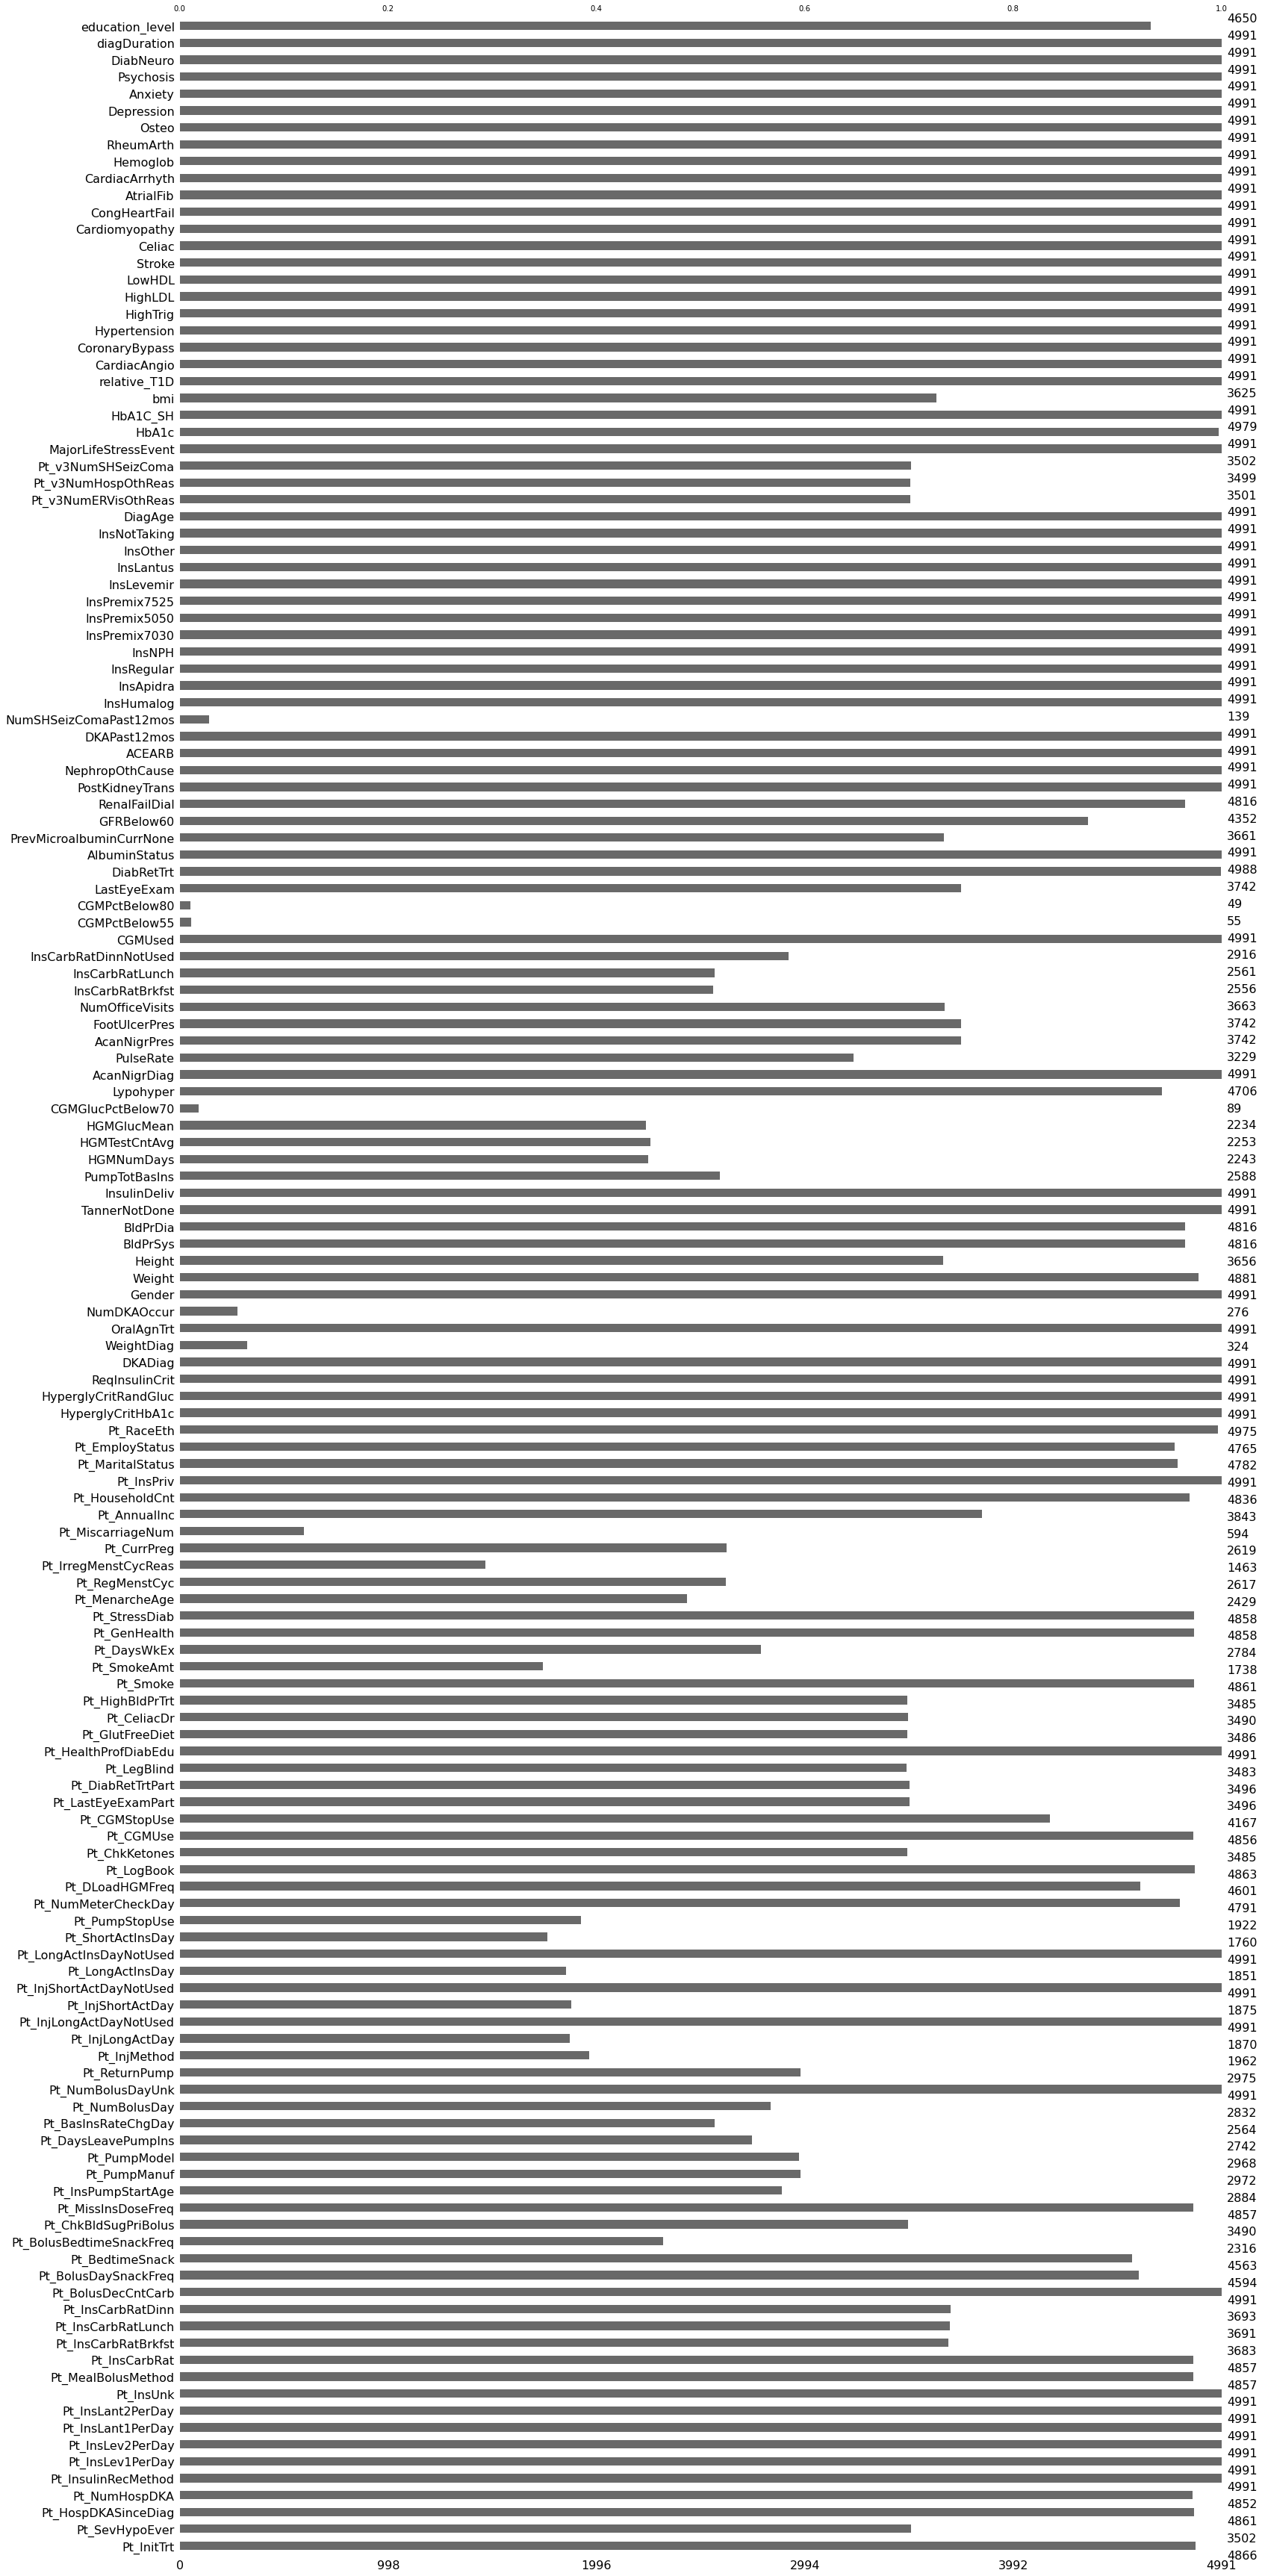

In [19]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [20]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [21]:
# use only for XGB classifier with missing values
# X_train_copy = X_train.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)
# X_test_copy = X_test.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train_copy = X_train_copy.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test_copy = X_test_copy.drop([ 'NumSHSeizComaPast12mos'], axis=1)
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train_copy = X_train_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test_copy = X_test_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
# if('Pt_SevHypoEver' in X_train.columns):
#     X_train_copy = X_train_copy.drop(['Pt_SevHypoEver'], axis=1)
#     X_test_copy = X_test_copy.drop(['Pt_SevHypoEver'], axis=1)

# feature_list = ['Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_InjShortActDay',
#        'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_GlutFreeDiet',
#        'Pt_Smoke', 'Pt_GenHealth', 'Pt_CurrPreg', 'Pt_MaritalStatus',
#        'Pt_EmployStatus', 'DKADiag', 'bmi', 'BldPrSys', 'PumpTotBasIns',
#        'AcanNigrDiag', 'AcanNigrPres', 'CGMUsed', 'AlbuminStatus',
#        'GFRBelow60', 'RenalFailDial',
#        'Pt_v3NumHospOthReas']

feature_list = ['Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_BolusDaySnackFreq',
       'Pt_InjLongActDay', 'Pt_LogBook', 'Pt_CGMUse', 'Pt_GlutFreeDiet',
       'Pt_GenHealth', 'Pt_CurrPreg', 'Pt_MaritalStatus', 'ReqInsulinCrit',
       'Height', 'BldPrSys', 'TannerNotDone', 'AcanNigrDiag',
       'NumOfficeVisits', 'CGMUsed', 'AlbuminStatus', 'GFRBelow60',
        'Pt_v3NumHospOthReas',
       'bmi', 'CardiacArrhyth', 'diagDuration']
X_train_copy = X_train_copy[feature_list]
X_test_copy = X_test_copy[feature_list]
    

In [22]:
kf = KFold(n_splits= 10, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values



from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()




def cross_val_with_missing_val(model,n_splits=5):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
#         X_test1 = train.iloc[test_index][X_train_copy.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model


    

    dfs = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        
        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1






#     dfs = []
#     y_true, y_pred = list(), list()
#     for train_index, test_index in cv.split(train, Y_train):

#         X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
#         X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index].loc[:,y_label]

# #         Train the model
#         model.fit(X_train1, y_train1) #Training the model

    return model



Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 8 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869

 
 ===========   Train Dataset    =============
train ROC score 

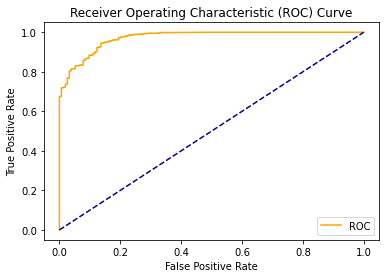

accuracy score:  94.24964936886396
              precision    recall  f1-score   support

         0.0       0.33      0.86      0.48       154
         1.0       1.00      0.95      0.97      4837

    accuracy                           0.94      4991
   macro avg       0.66      0.90      0.73      4991
weighted avg       0.97      0.94      0.95      4991



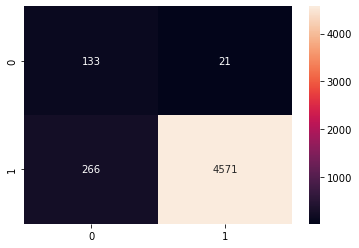

Accuracy of XGB on training set: 0.98


 ===========   Test Dataset    =============
Threshold value is: 2.7659059


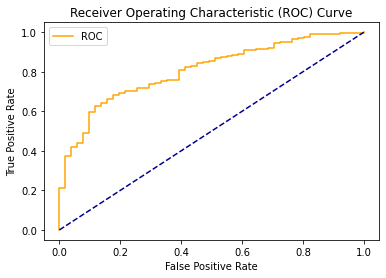

accuracy score:  63.46153846153846
              precision    recall  f1-score   support

         0.0       0.07      0.88      0.13        51
         1.0       0.99      0.63      0.77      1613

    accuracy                           0.63      1664
   macro avg       0.53      0.75      0.45      1664
weighted avg       0.97      0.63      0.75      1664



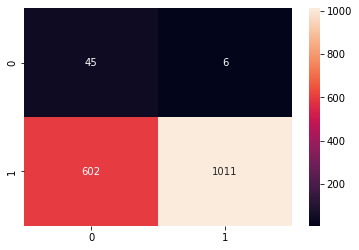

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8062


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.88235294 0.62678239]
average accuracy:  0.7545676671164436
f1 0.7688212927756654


In [23]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
#         scale_pos_weight = 0.4,
#         n_jobs = 0,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )

# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model, 10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))

<AxesSubplot:>

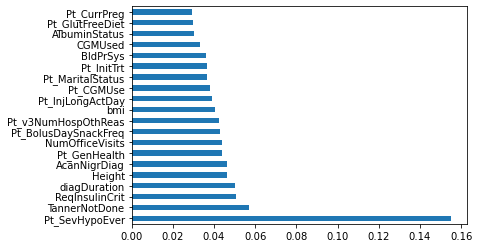

In [24]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feat_importances.nlargest(20).plot(kind='barh')


Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869

 
 ===========   Train Dataset    =============
train ROC score 0.

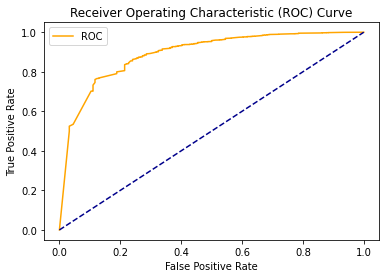

accuracy score:  76.45762372270086
              precision    recall  f1-score   support

         0.0       0.11      0.88      0.19       154
         1.0       1.00      0.76      0.86      4837

    accuracy                           0.76      4991
   macro avg       0.55      0.82      0.53      4991
weighted avg       0.97      0.76      0.84      4991



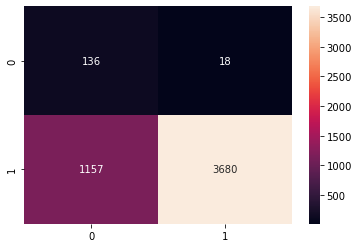

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9701307602287151


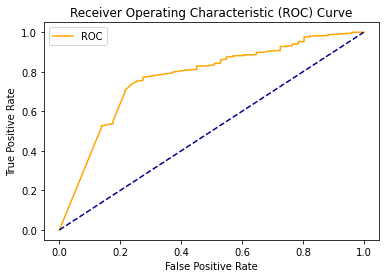

accuracy score:  73.73798076923077
              precision    recall  f1-score   support

         0.0       0.08      0.76      0.15        51
         1.0       0.99      0.74      0.84      1613

    accuracy                           0.74      1664
   macro avg       0.54      0.75      0.50      1664
weighted avg       0.96      0.74      0.82      1664



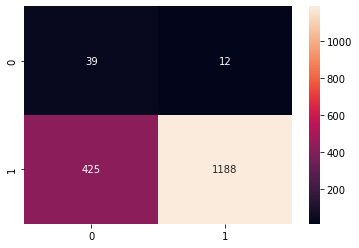



 ===========   ROC    =============
roc_auc = 0.7714


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.76470588 0.73651581]
average accuracy:  0.7506108457021989
f1 0.8446498400284393


In [25]:

import lightgbm as ltb

# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True,
                         learning_rate = 0.001, 
                         max_depth =5, random_state=0 )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model,10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

# test_acc = model.score(X_test_copy, Y_test)
# print('Accuracy of XGB classifier on test set: {:.2f}'
#      .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))

<AxesSubplot:>

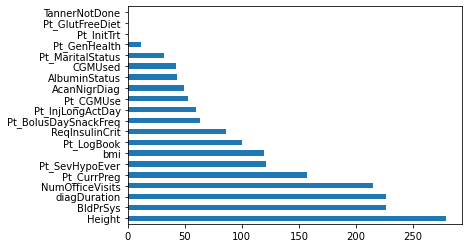

In [26]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feat_importances.nlargest(20).plot(kind='barh')


In [27]:
   
X_train.update(X_train[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay',
             'Pt_InsUnk','HyperglyCritHbA1c']].fillna(0))

X_test.update(X_test[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay',
             'Pt_InsUnk','HyperglyCritHbA1c']].fillna(0))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
# imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
imputeX = IterativeImputer(missing_values=np.nan,sample_posterior= True,max_iter=15,
                           initial_strategy='most_frequent', random_state=0)

X_train = imputeX.fit_transform(X_train)


In [29]:
# ###############
# import datawig

# imputer = datawig.SimpleImputer()
# imputer.fit(train_df = X_train, num_epochs=50)
# X_test = imputer.predict(X_test)
# X_train = imputer.predict(X_train)

In [30]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)



# Scale data

In [31]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))


## Feature Selection

In [32]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [33]:


#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [34]:
# Feature selection
selected, fs, idx = select_features(select, feature)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:55:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:56:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [35]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)



Index(['Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_BolusDaySnackFreq',
       'Pt_InjLongActDay', 'Pt_LogBook', 'Pt_CGMUse', 'Pt_GlutFreeDiet',
       'Pt_GenHealth', 'Pt_CurrPreg', 'Pt_MaritalStatus', 'ReqInsulinCrit',
       'Height', 'BldPrSys', 'TannerNotDone', 'AcanNigrDiag',
       'NumOfficeVisits', 'CGMUsed', 'AlbuminStatus', 'GFRBelow60',
       'NumSHSeizComaPast12mos', 'Pt_v3NumHospOthReas', 'Pt_v3NumSHSeizComa',
       'bmi', 'CardiacArrhyth', 'diagDuration'],
      dtype='object')
(6655, 25)


In [36]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [37]:
# X_train.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)
# X_test.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)

# if('Pt_SevHypoEver' in X_train.columns):
#     X_train = X_train.drop(['Pt_SevHypoEver'], axis=1)
#     X_test = X_test.drop(['Pt_SevHypoEver'], axis=1)
if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train = X_train.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test = X_test.drop([ 'NumSHSeizComaPast12mos'], axis=1)
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train = X_train.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test = X_test.drop(['Pt_v3NumSHSeizComa'], axis=1)


### Common functions

In [38]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model, n_splits=10):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



In [39]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
#     optimal_idx = np.argmax(sqrt(tpr * (1-fpr)))
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr)
    plt.show()
    return optimal_threshold

In [40]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))
    
    print('f1', metrics.f1_score(pred, Y_test))    

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Train ROC
0.9084847858364501
Threshold value is: 0.9437215227215835

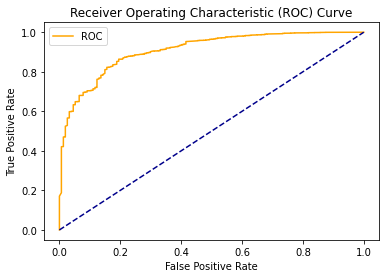

Test ROC
0.7711729453095559
Threshold value is: 0.9801365217495809


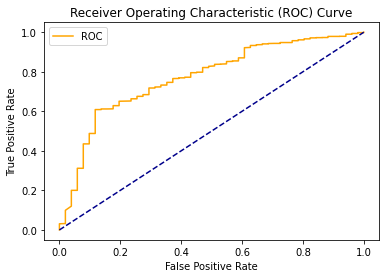


 
 =====================   Train Dataset    ======================
86.19515127229013
              precision    recall  f1-score   support

         0.0       0.16      0.81      0.26       154
         1.0       0.99      0.86      0.92      4837

    accuracy                           0.86      4991
   macro avg       0.58      0.83      0.59      4991
weighted avg       0.97      0.86      0.90      4991



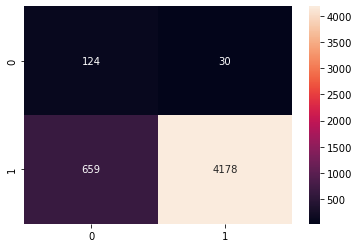

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
61.71875
              precision    recall  f1-score   support

         0.0       0.07      0.88      0.12        51
         1.0       0.99      0.61      0.76      1613

    accuracy                           0.62      1664
   macro avg       0.53      0.75      0.44      1664
weighted avg       0.97      0.62      0.74      1664



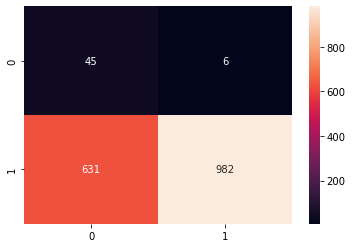

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.7712


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.88235294 0.60880347]
average accuracy:  0.7455782064840815
f1 0.7550941945405614


In [41]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

ltb_model=ltb.LGBMClassifier(use_missing = False,
                         learning_rate = 0.01, 
                         max_depth =4, random_state=0 )
# adaboost.fit(X_train, Y_train)
ltb_model = cross_val(ltb_model, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(ltb_model, X_train, Y_train)
pred_train = (ltb_model.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(ltb_model, X_test, Y_test)
pred = (ltb_model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(ltb_model, X_train, Y_train, pred_train)
test_results(ltb_model, X_test, Y_test, pred)

# ROC
ROC_results(ltb_model, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(ltb_model, Y_test, pred)


<AxesSubplot:>

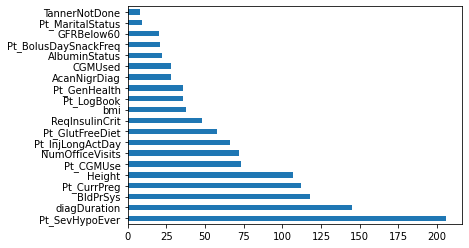

In [42]:
feat_importances = pd.Series(ltb_model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Train ROC
0.8484242137849746
Threshold value is: 0.6228901318201233

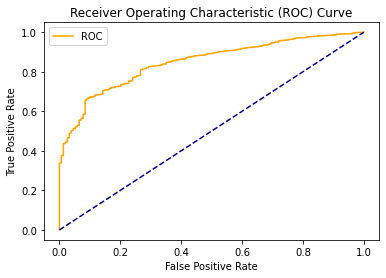

Test ROC
0.7484956784945844
Threshold value is: 0.6195439644105782


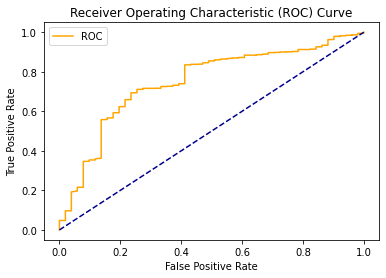


 
 =====================   Train Dataset    ======================
67.3211781206171
              precision    recall  f1-score   support

         0.0       0.08      0.91      0.15       154
         1.0       1.00      0.67      0.80      4837

    accuracy                           0.67      4991
   macro avg       0.54      0.79      0.47      4991
weighted avg       0.97      0.67      0.78      4991



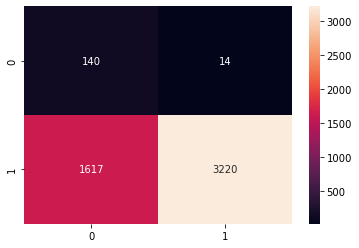

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
69.59134615384616
              precision    recall  f1-score   support

         0.0       0.07      0.76      0.13        51
         1.0       0.99      0.69      0.82      1613

    accuracy                           0.70      1664
   macro avg       0.53      0.73      0.47      1664
weighted avg       0.96      0.70      0.79      1664



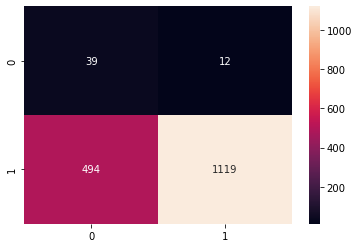

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.7485


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.76470588 0.69373838]
average accuracy:  0.7292221290251997
f1 0.8155976676384841


In [43]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0, learning_rate=0.008, n_estimators=1000, algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

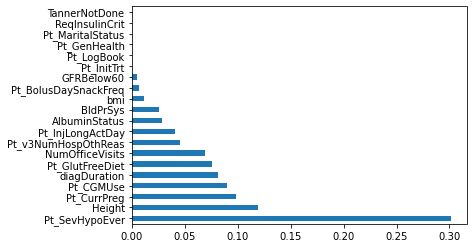

In [44]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.9659318637274549, doublecheck: 0.9659318637274549
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Train ROC
0.9853886035403504
Threshold value is: 1.5227464


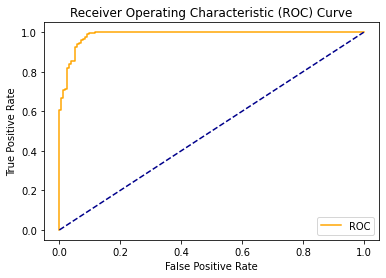

Test ROC
0.7530359943109295
Threshold value is: 3.043055


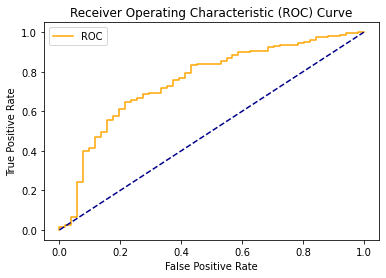


 
 =====================   Train Dataset    ======================
98.61751152073732
              precision    recall  f1-score   support

         0.0       0.72      0.91      0.80       154
         1.0       1.00      0.99      0.99      4837

    accuracy                           0.99      4991
   macro avg       0.86      0.95      0.90      4991
weighted avg       0.99      0.99      0.99      4991



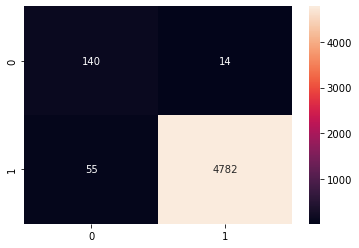

Accuracy of on training set: 0.99


 =====================   Test Dataset    =======================
64.90384615384616
              precision    recall  f1-score   support

         0.0       0.07      0.78      0.12        51
         1.0       0.99      0.64      0.78      1613

    accuracy                           0.65      1664
   macro avg       0.53      0.71      0.45      1664
weighted avg       0.96      0.65      0.76      1664



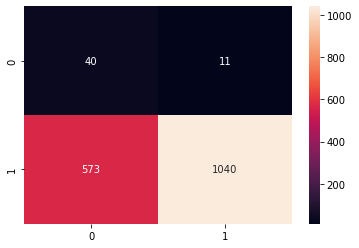

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.753


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.78431373 0.64476131]
average accuracy:  0.7145375199056684
f1 0.7807807807807808


In [45]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 6, #values between(3-10)
#         max_delta_step = 10,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute,10)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

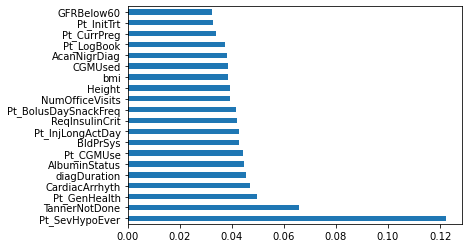

In [46]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.94, doublecheck: 0.94
Accuracy for the fold no. 2 on the test set: 0.9378757515030061, doublecheck: 0.9378757515030061
Accuracy for the fold no. 3 on the test set: 0.935871743486974, doublecheck: 0.935871743486974
Accuracy for the fold no. 4 on the test set: 0.9418837675350702, doublecheck: 0.9418837675350702
Accuracy for the fold no. 5 on the test set: 0.9418837675350702, doublecheck: 0.9418837675350702
Accuracy for the fold no. 6 on the test set: 0.9318637274549099, doublecheck: 0.9318637274549099
Accuracy for the fold no. 7 on the test set: 0.9418837675350702, doublecheck: 0.9418837675350702
Accuracy for the fold no. 8 on the test set: 0.9318637274549099, doublecheck: 0.9318637274549099
Accuracy for the fold no. 9 on the test set: 0.9238476953907816, doublecheck: 0.9238476953907816
Accuracy for the fold no. 10 on the test set: 0.9378757515030061, doublecheck: 0.9378757515030061
Train ROC
0.9649361389076089
Threshold value is: 0.58240252

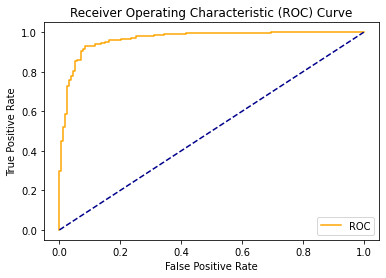

Test ROC
0.7242016459404593
Threshold value is: 0.8670689155093116


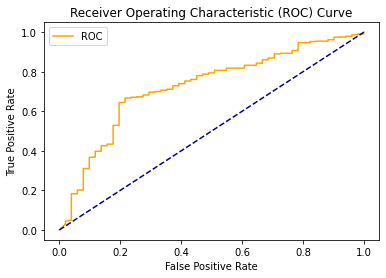


 
 =====================   Train Dataset    ======================
92.78701662993389
              precision    recall  f1-score   support

         0.0       0.29      0.92      0.44       154
         1.0       1.00      0.93      0.96      4837

    accuracy                           0.93      4991
   macro avg       0.64      0.92      0.70      4991
weighted avg       0.98      0.93      0.95      4991



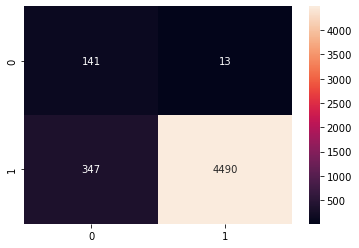

Accuracy of on training set: 0.96


 =====================   Test Dataset    =======================
67.12740384615384
              precision    recall  f1-score   support

         0.0       0.07      0.78      0.13        51
         1.0       0.99      0.67      0.80      1613

    accuracy                           0.67      1664
   macro avg       0.53      0.73      0.46      1664
weighted avg       0.96      0.67      0.78      1664



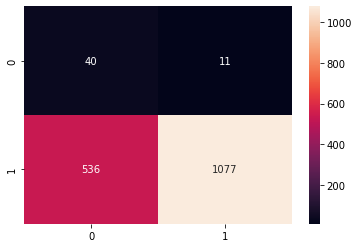

Accuracy of classifier on test set: 0.94


 =======================   Test-ROC    =========================
roc_auc = 0.7242


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.78431373 0.66769994]
average accuracy:  0.7260068317469579
f1 0.79748241392077


In [47]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=10,
                             n_estimators = feature,
                             criterion = 'entropy', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced_subsample', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.001,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf,10)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(rf, X_test, Y_test)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

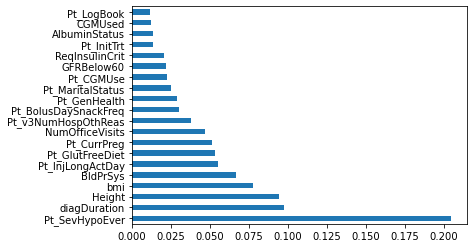

In [48]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

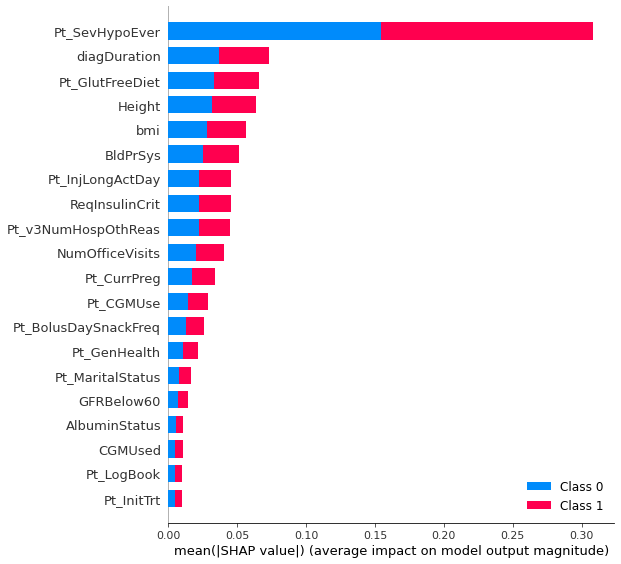

In [49]:
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Model 3 LogisticRegression

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 1 on the test set: 0.71, doublecheck: 0.71
Accuracy for the fold no. 2 on the test set: 0.717434869739479, doublecheck: 0.717434869739479


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 3 on the test set: 0.6973947895791583, doublecheck: 0.6973947895791583
Accuracy for the fold no. 4 on the test set: 0.7114228456913828, doublecheck: 0.7114228456913828


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 5 on the test set: 0.7194388777555111, doublecheck: 0.7194388777555111
Accuracy for the fold no. 6 on the test set: 0.6953907815631263, doublecheck: 0.6953907815631263


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 7 on the test set: 0.7194388777555111, doublecheck: 0.7194388777555111
Accuracy for the fold no. 8 on the test set: 0.6533066132264529, doublecheck: 0.6533066132264529


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 9 on the test set: 0.7134268537074149, doublecheck: 0.7134268537074149
Accuracy for the fold no. 10 on the test set: 0.7154308617234469, doublecheck: 0.7154308617234469
Train ROC
0.7717687522318493
Threshold value is: 0.5775331159166974


The max_iter was reached which means the coef_ did not converge


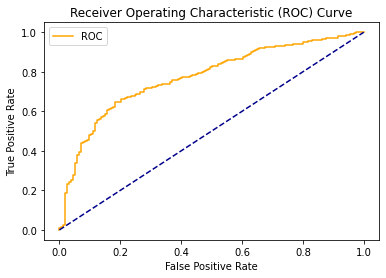

Test ROC
0.719837594058082
Threshold value is: 0.6106432269450738


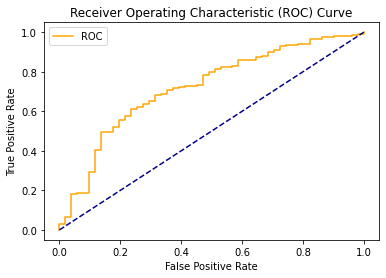


 
 =====================   Train Dataset    ======================
65.25746343418153
              precision    recall  f1-score   support

         0.0       0.07      0.82      0.13       154
         1.0       0.99      0.65      0.78      4837

    accuracy                           0.65      4991
   macro avg       0.53      0.73      0.46      4991
weighted avg       0.96      0.65      0.76      4991



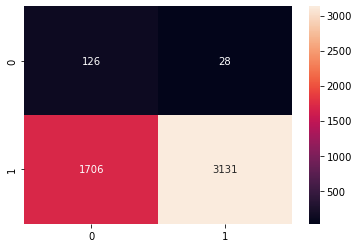

Accuracy of on training set: 0.72


 =====================   Test Dataset    =======================
61.47836538461539
              precision    recall  f1-score   support

         0.0       0.06      0.76      0.11        51
         1.0       0.99      0.61      0.75      1613

    accuracy                           0.61      1664
   macro avg       0.52      0.69      0.43      1664
weighted avg       0.96      0.61      0.73      1664



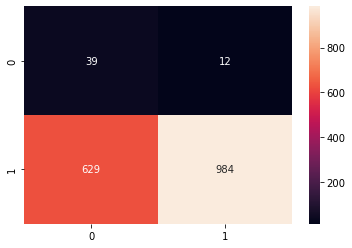

Accuracy of classifier on test set: 0.71


 =======================   Test-ROC    =========================
roc_auc = 0.7198


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.76470588 0.6100434 ]
average accuracy:  0.6873746398745486
f1 0.754311996933691


In [50]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg,10)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

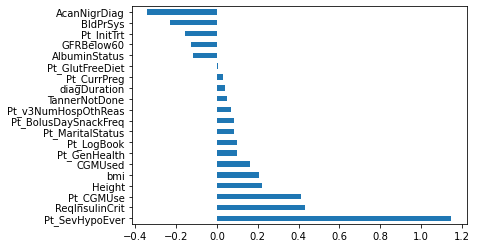

In [51]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 3 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 6 on the test set: 0.9659318637274549, doublecheck: 0.9659318637274549
Accuracy for the fold no. 7 on the test set: 0.9719438877755511, doublecheck: 0.9719438877755511
Accuracy for the fold no. 8 on the test set: 0.9659318637274549, doublecheck: 0.9659318637274549
Accuracy for the fold no. 9 on the test set: 0.9559118236472945, doublecheck: 0.9559118236472945
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Train ROC
0.7915258196424209
Threshold value is: 0.972638

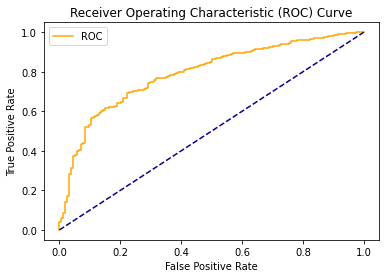

Test ROC
0.7295260323596271
Threshold value is: 0.9789680999325694


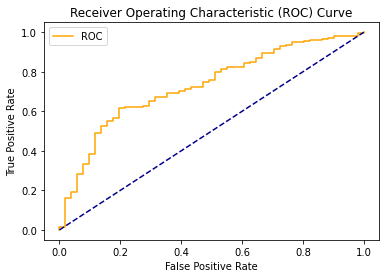


 
 =====================   Train Dataset    ======================
69.68543378080545
              precision    recall  f1-score   support

         0.0       0.08      0.78      0.14       154
         1.0       0.99      0.69      0.82      4837

    accuracy                           0.70      4991
   macro avg       0.53      0.74      0.48      4991
weighted avg       0.96      0.70      0.80      4991



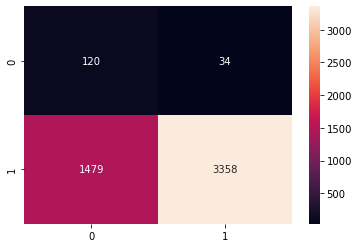

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
62.13942307692307
              precision    recall  f1-score   support

         0.0       0.06      0.80      0.12        51
         1.0       0.99      0.62      0.76      1613

    accuracy                           0.62      1664
   macro avg       0.53      0.71      0.44      1664
weighted avg       0.96      0.62      0.74      1664



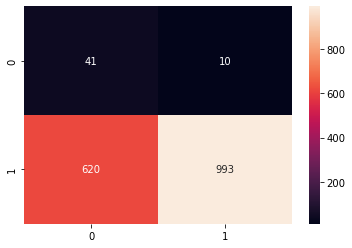

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.7295


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.80392157 0.61562306]
average accuracy:  0.709772315621847
f1 0.7591743119266054


In [52]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(lda, X_test, Y_test)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


## Model 7- Gaussian Naive Bayes

Accuracy for the fold no. 1 on the test set: 0.964, doublecheck: 0.964
Accuracy for the fold no. 2 on the test set: 0.9639278557114228, doublecheck: 0.9639278557114228
Accuracy for the fold no. 3 on the test set: 0.9639278557114228, doublecheck: 0.9639278557114228
Accuracy for the fold no. 4 on the test set: 0.9639278557114228, doublecheck: 0.9639278557114228
Accuracy for the fold no. 5 on the test set: 0.9579158316633266, doublecheck: 0.9579158316633266
Accuracy for the fold no. 6 on the test set: 0.9539078156312625, doublecheck: 0.9539078156312625
Accuracy for the fold no. 7 on the test set: 0.9619238476953907, doublecheck: 0.9619238476953907
Accuracy for the fold no. 8 on the test set: 0.9519038076152304, doublecheck: 0.9519038076152304
Accuracy for the fold no. 9 on the test set: 0.9478957915831663, doublecheck: 0.9478957915831663
Accuracy for the fold no. 10 on the test set: 0.9599198396793587, doublecheck: 0.9599198396793587
Train ROC
0.7433031099559939
Threshold value is: 0.9936

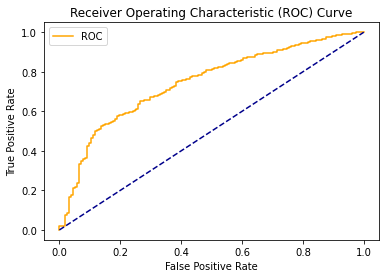

Test ROC
0.6940422790318855
Threshold value is: 0.9915673615843736


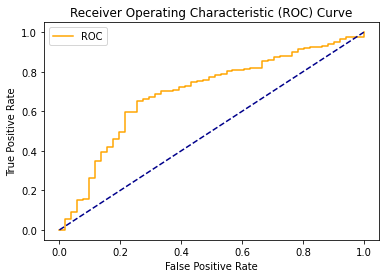


 
 =====================   Train Dataset    ======================
53.836906431576836
              precision    recall  f1-score   support

         0.0       0.06      0.86      0.10       154
         1.0       0.99      0.53      0.69      4837

    accuracy                           0.54      4991
   macro avg       0.52      0.70      0.40      4991
weighted avg       0.96      0.54      0.67      4991



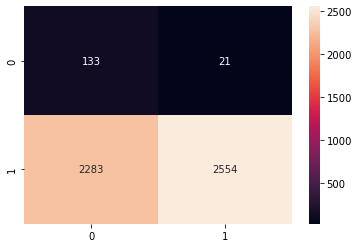

Accuracy of on training set: 0.96


 =====================   Test Dataset    =======================
65.5048076923077
              precision    recall  f1-score   support

         0.0       0.06      0.75      0.12        51
         1.0       0.99      0.65      0.79      1613

    accuracy                           0.66      1664
   macro avg       0.53      0.70      0.45      1664
weighted avg       0.96      0.66      0.77      1664



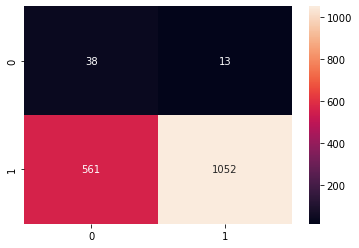

Accuracy of classifier on test set: 0.95


 =======================   Test-ROC    =========================
roc_auc = 0.694


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.74509804 0.65220087]
average accuracy:  0.6986494535818046
f1 0.7856609410007468


In [53]:
gnb = GaussianNB(priors=None, var_smoothing=1)
gnb = cross_val(gnb)
# gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)
